# Analysis of Predictions Produced with Chunks

This script analyzes all pickle files in `./data/darts/{n_chunks}_chunks/`, starting with `confusion_matrix`, i.e. all model-level and all chunk-level matrices. At the moment, the paths are adapted for local execution.

## Analysis of Model-level Matrices

### Extract All Generated Model-level Matrices

In [1]:
from IPython.display import display

import os
import pandas as pd
import pickle5 as pickle

# Define number of chunks taken to adjust
n_chunks = 1000

# Define path to all model-level matrices produced by prediction
path_to_model_matrices = f'../../data/darts/{n_chunks}_chunks'

# Collect pickle file names of model-level matrices
model_matrix_filenames = list()

for file in os.listdir(path_to_model_matrices):
    if os.path.isfile(os.path.join(path_to_model_matrices, file)) and \
            file.startswith('confusion_matrix_models') and file.endswith('.pickle'):
        model_matrix_filenames.append(file)

# Concat all found matrices into result matrix
result_matrix_models = pd.DataFrame(columns=['ID', 'PARAMETER', 'MODEL', 'ENDOGENOUS', 'EXOGENOUS', 'FORECAST_TYPE',
                                             'FIRST_FORECAST', 'ALARM_TYPE', 'FP', 'TP', 'FN', 'TN', 'N_CHUNKS',
                                             'N_ITERATIONS'])

for filename in model_matrix_filenames:
    # Read file
    current_matrix_f = open(f'{path_to_model_matrices}/{filename}', 'rb')
    current_matrix = pickle.load(current_matrix_f)
    current_matrix_f.close()

    # Append current matrix to result matrix
    result_matrix_models = pd.concat([result_matrix_models, current_matrix])

# Sort result matrix for better readability
result_matrix_models.sort_values(by=['PARAMETER', 'MODEL', 'ENDOGENOUS'], inplace=True)

# Reset index
result_matrix_models.reset_index(inplace=True, drop=True)

# Show result matrix per parameter
display(result_matrix_models[result_matrix_models['PARAMETER'] == 'HR'])
display(result_matrix_models[result_matrix_models['PARAMETER'] == 'BP'])

,ID,PARAMETER,MODEL,ENDOGENOUS,EXOGENOUS,FORECAST_TYPE,FIRST_FORECAST,ALARM_TYPE,FP,TP,FN,TN,N_CHUNKS,N_ITERATIONS
9,HR_R_02_H,HR,GRU,MAX,MEDIAN,Expanding,13,High,0,0,36,4618,134,4654
10,HR_R_01_B,HR,GRU,MEDIAN,n/a,Expanding,13,Both,0,0,53,9255,268,9308
11,HR_R_03_L,HR,GRU,MIN,MEDIAN,Expanding,13,Low,2,0,21,4631,134,4654
12,HR_R_02_H,HR,LSTM,MAX,MEDIAN,Expanding,13,High,0,0,36,4618,134,4654
13,HR_R_01_B,HR,LSTM,MEDIAN,n/a,Expanding,13,Both,9,0,53,9246,268,9308
14,HR_R_03_L,HR,LSTM,MIN,MEDIAN,Expanding,13,Low,4,0,21,4629,134,4654
15,HR_R_02_H,HR,RNN,MAX,MEDIAN,Expanding,13,High,0,0,36,4618,134,4654
16,HR_R_01_B,HR,RNN,MEDIAN,n/a,Expanding,13,Both,1,0,53,9254,268,9308
17,HR_R_03_L,HR,RNN,MIN,MEDIAN,Expanding,13,Low,0,0,21,4633,134,4654


,ID,PARAMETER,MODEL,ENDOGENOUS,EXOGENOUS,FORECAST_TYPE,FIRST_FORECAST,ALARM_TYPE,FP,TP,FN,TN,N_CHUNKS,N_ITERATIONS
0,BP_R_02_H,BP,GRU,MAX,MEDIAN,Expanding,13,High,45,17,15,309,41,386
1,BP_R_01_B,BP,GRU,MEDIAN,n/a,Expanding,13,Both,42,14,25,691,82,772
2,BP_R_03_L,BP,GRU,MIN,MEDIAN,Expanding,13,Low,0,0,7,379,41,386
3,BP_R_02_H,BP,LSTM,MAX,MEDIAN,Expanding,13,High,74,16,16,280,41,386
4,BP_R_01_B,BP,LSTM,MEDIAN,n/a,Expanding,13,Both,71,16,23,662,82,772
5,BP_R_03_L,BP,LSTM,MIN,MEDIAN,Expanding,13,Low,3,0,7,376,41,386
6,BP_R_02_H,BP,RNN,MAX,MEDIAN,Expanding,13,High,32,16,16,322,41,386
7,BP_R_01_B,BP,RNN,MEDIAN,n/a,Expanding,13,Both,46,16,23,687,82,772
8,BP_R_03_L,BP,RNN,MIN,MEDIAN,Expanding,13,Low,0,0,7,379,41,386


### Add Accuracy Metrics and Save as Parquet File

In [2]:
# Calculate metrics (see https://en.wikipedia.org/wiki/Sensitivity_and_specificity for more information)
result_matrix_models['FPR'] = result_matrix_models['FP'] / (result_matrix_models['FP'] + result_matrix_models['TN'])
result_matrix_models['TPR'] = result_matrix_models['TP'] / (result_matrix_models['TP'] + result_matrix_models['FN'])
result_matrix_models['FNR'] = result_matrix_models['FN'] / (result_matrix_models['TP'] + result_matrix_models['FN'])
result_matrix_models['TNR'] = result_matrix_models['TN'] / (result_matrix_models['FP'] + result_matrix_models['TN'])

result_matrix_models['ACC'] = (result_matrix_models['TP'] + result_matrix_models['TN']) / \
                              (result_matrix_models['TP'] + result_matrix_models['FN'] + result_matrix_models['FP'] + result_matrix_models['TN'])
result_matrix_models['F1S'] = result_matrix_models['TP'] / \
                              (result_matrix_models['TP'] + 0.5 * (result_matrix_models['FP'] + result_matrix_models['FN']))

# Round all floats to 4 decimal places
# Note: round() does not work for floats with many decimal places
decimals = 4
for col in ['FPR', 'TPR', 'FNR', 'TNR', 'ACC', 'F1S']:
    result_matrix_models[col] = result_matrix_models[col].apply(lambda x: round(x, decimals))

# Move cols to end for similarity with ARIMA results
result_matrix_models = result_matrix_models[['ID', 'PARAMETER', 'MODEL', 'ENDOGENOUS', 'EXOGENOUS', 'FORECAST_TYPE',
                                             'FIRST_FORECAST', 'ALARM_TYPE', 'FP', 'TP', 'FN', 'TN', 'FPR', 'TPR',
                                             'FNR', 'TNR', 'ACC', 'F1S', 'N_CHUNKS', 'N_ITERATIONS']]

# Show complemented result matrix per parameter
display(result_matrix_models[result_matrix_models['PARAMETER'] == 'HR'])
display(result_matrix_models[result_matrix_models['PARAMETER'] == 'BP'])

# Save result matrix as parquet
result_matrix_models.to_parquet(f'../../data/darts/{n_chunks}_chunks/result_matrix_models.parquet', engine='pyarrow')

,ID,PARAMETER,MODEL,ENDOGENOUS,EXOGENOUS,FORECAST_TYPE,FIRST_FORECAST,ALARM_TYPE,FP,TP,FN,TN,FPR,TPR,FNR,TNR,ACC,F1S,N_CHUNKS,N_ITERATIONS
9,HR_R_02_H,HR,GRU,MAX,MEDIAN,Expanding,13,High,0,0,36,4618,0.0000,0.0,1.0,1.0000,0.9923,0.0,134,4654
10,HR_R_01_B,HR,GRU,MEDIAN,n/a,Expanding,13,Both,0,0,53,9255,0.0000,0.0,1.0,1.0000,0.9943,0.0,268,9308
11,HR_R_03_L,HR,GRU,MIN,MEDIAN,Expanding,13,Low,2,0,21,4631,0.0004,0.0,1.0,0.9996,0.9951,0.0,134,4654
12,HR_R_02_H,HR,LSTM,MAX,MEDIAN,Expanding,13,High,0,0,36,4618,0.0000,0.0,1.0,1.0000,0.9923,0.0,134,4654
13,HR_R_01_B,HR,LSTM,MEDIAN,n/a,Expanding,13,Both,9,0,53,9246,0.0010,0.0,1.0,0.9990,0.9933,0.0,268,9308
14,HR_R_03_L,HR,LSTM,MIN,MEDIAN,Expanding,13,Low,4,0,21,4629,0.0009,0.0,1.0,0.9991,0.9946,0.0,134,4654
15,HR_R_02_H,HR,RNN,MAX,MEDIAN,Expanding,13,High,0,0,36,4618,0.0000,0.0,1.0,1.0000,0.9923,0.0,134,4654
16,HR_R_01_B,HR,RNN,MEDIAN,n/a,Expanding,13,Both,1,0,53,9254,0.0001,0.0,1.0,0.9999,0.9942,0.0,268,9308
17,HR_R_03_L,HR,RNN,MIN,MEDIAN,Expanding,13,Low,0,0,21,4633,0.0000,0.0,1.0,1.0000,0.9955,0.0,134,4654


,ID,PARAMETER,MODEL,ENDOGENOUS,EXOGENOUS,FORECAST_TYPE,FIRST_FORECAST,ALARM_TYPE,FP,TP,FN,TN,FPR,TPR,FNR,TNR,ACC,F1S,N_CHUNKS,N_ITERATIONS
0,BP_R_02_H,BP,GRU,MAX,MEDIAN,Expanding,13,High,45,17,15,309,0.1271,0.5312,0.4688,0.8729,0.8446,0.3617,41,386
1,BP_R_01_B,BP,GRU,MEDIAN,n/a,Expanding,13,Both,42,14,25,691,0.0573,0.3590,0.6410,0.9427,0.9132,0.2947,82,772
2,BP_R_03_L,BP,GRU,MIN,MEDIAN,Expanding,13,Low,0,0,7,379,0.0000,0.0000,1.0000,1.0000,0.9819,0.0000,41,386
3,BP_R_02_H,BP,LSTM,MAX,MEDIAN,Expanding,13,High,74,16,16,280,0.2090,0.5000,0.5000,0.7910,0.7668,0.2623,41,386
4,BP_R_01_B,BP,LSTM,MEDIAN,n/a,Expanding,13,Both,71,16,23,662,0.0969,0.4103,0.5897,0.9031,0.8782,0.2540,82,772
5,BP_R_03_L,BP,LSTM,MIN,MEDIAN,Expanding,13,Low,3,0,7,376,0.0079,0.0000,1.0000,0.9921,0.9741,0.0000,41,386
6,BP_R_02_H,BP,RNN,MAX,MEDIAN,Expanding,13,High,32,16,16,322,0.0904,0.5000,0.5000,0.9096,0.8756,0.4000,41,386
7,BP_R_01_B,BP,RNN,MEDIAN,n/a,Expanding,13,Both,46,16,23,687,0.0628,0.4103,0.5897,0.9372,0.9106,0.3168,82,772
8,BP_R_03_L,BP,RNN,MIN,MEDIAN,Expanding,13,Low,0,0,7,379,0.0000,0.0000,1.0000,1.0000,0.9819,0.0000,41,386


### Plot Ratios

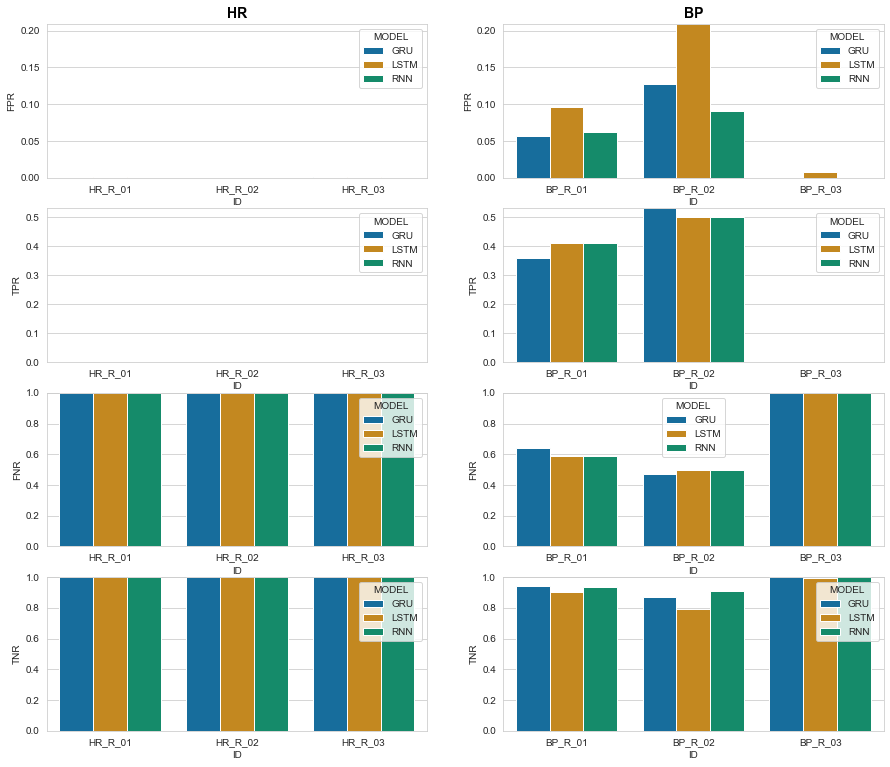

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# "Group" result matrix by prefix of ID
plotdata = result_matrix_models.replace(['_H', '_L', '_B'], ['', '', ''], regex=True)

# Create subplots
sns.set_style('whitegrid')
fig, axs = plt.subplots(
    nrows=4,
    ncols=2, # TODO: adjust if O2 is added
    figsize=(15, 13),
    dpi=72
    )

# Define y-limits
fpr_ylimits = [0, max(result_matrix_models.FPR)]
tpr_ylimits = [0, max(result_matrix_models.TPR)]
fnr_ylimits = [0, max(result_matrix_models.FNR)]
tnr_ylimits = [0, max(result_matrix_models.TNR)]

# Actual plots
# TODO: execute again with O2
for i, parameter in enumerate(['HR', 'BP']):
    sns.barplot(
        ax=axs[0, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='FPR',
        hue='MODEL',
        palette=sns.color_palette('colorblind'),
        ci=None,
        order=[f'{parameter}_R_01', f'{parameter}_R_02', f'{parameter}_R_03'])
    axs[0, i].set_title(str(parameter), fontweight='bold', color= 'black', fontsize=14)
    axs[0, i].set_ylim(fpr_ylimits)

    sns.barplot(
        ax=axs[1, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='TPR',
        hue='MODEL',
        palette=sns.color_palette('colorblind'),
        ci=None,
        order=[f'{parameter}_R_01', f'{parameter}_R_02', f'{parameter}_R_03'])
    axs[1, i].set_ylim(tpr_ylimits)

    sns.barplot(
        ax=axs[2, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='FNR',
        hue='MODEL',
        palette=sns.color_palette('colorblind'),
        ci=None,
        order=[f'{parameter}_R_01', f'{parameter}_R_02', f'{parameter}_R_03'])
    axs[2, i].set_ylim(fnr_ylimits)

    sns.barplot(
        ax = axs[3, i],
        data = plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='TNR',
        hue='MODEL',
        palette = sns.color_palette('colorblind'),
        ci=None,
        order=[f'{parameter}_R_01', f'{parameter}_R_02', f'{parameter}_R_03'])
    axs[3, i].set_ylim(tnr_ylimits)

plt.show(fig)
#fig.savefig(f'../../plots/darts/{n_chunks}_chunks/ratios_model_result_matrix.png', dpi=1200)

### Plot Accuracy and F1 Score

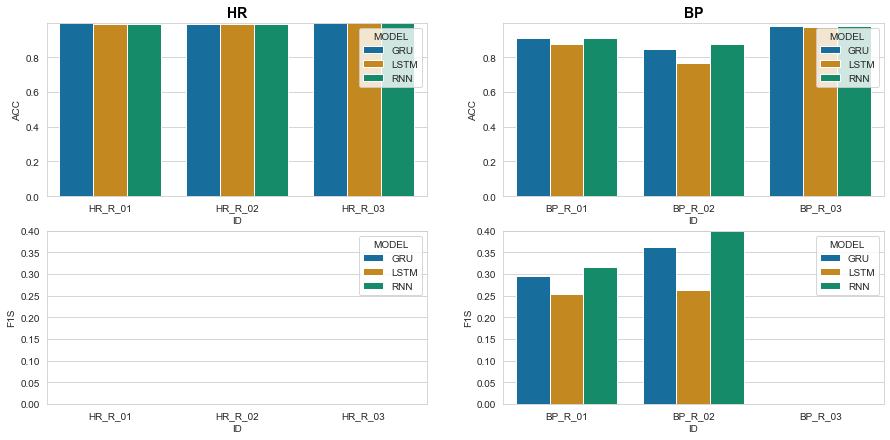

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# "Group" result matrix by prefix of ID
plotdata = result_matrix_models.replace(['_H', '_L', '_B'], ['', '', ''], regex=True)

# Create subplots
sns.set_style('whitegrid')
fig, axs = plt.subplots(
    nrows=2,
    ncols=2, # TODO: adjust if O2 is added
    figsize=(15, 7),
    dpi=72
    )

# Define y-limits
acc_ylimits = [0, max(result_matrix_models.ACC)]
f1s_ylimits = [0, max(result_matrix_models.F1S)]

# Actual plot
# TODO: execute again with O2
for i, parameter in enumerate(['HR', 'BP']):

    sns.barplot(
        ax=axs[0, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='ACC',
        hue='MODEL',
        palette=sns.color_palette('colorblind'),
        ci=None,
        order=[f'{parameter}_R_01', f'{parameter}_R_02', f'{parameter}_R_03'])
    axs[0, i].set_title(str(parameter), fontweight='bold', color= 'black', fontsize=14)
    axs[0, i].set_ylim(acc_ylimits)

    sns.barplot(
        ax=axs[1, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='F1S',
        hue='MODEL',
        palette=sns.color_palette('colorblind'),
        ci=None,
        order=[f'{parameter}_R_01', f'{parameter}_R_02', f'{parameter}_R_03'])
    axs[1, i].set_ylim(f1s_ylimits)

plt.show(fig)
#fig.savefig(f'../../plots/darts/{n_chunks}_chunks/acc_f1s_model_result_matrix.png', dpi=1200)

## Analysis of Chunk-level Matrices

### Print One Chunk-level Matrix

In [5]:
import pickle5 as pickle

# Define parameters to adjust
n_chunks = 1000
model_type = 'RNN'
parameter = 'bp'
endogenous_input = 'MEDIAN'

# Define path to all chunk-level matrices produced by prediction
path_to_chunk_matrices = f'../../data/darts/{n_chunks}_chunks'

# Read chunk-specific matrix
chunks_matrix_f = open(f'{path_to_chunk_matrices}/confusion_matrix_chunks_{model_type}_{parameter}_{endogenous_input}.pickle', 'rb')
chunks_matrix = pickle.load(chunks_matrix_f)
chunks_matrix_f.close()

# Show chunk-specific matrix
display(chunks_matrix)

,CHUNK_ID,ALARM_TYPE,N_ITERATIONS,FP,TP,FN,TN
0,200001.0_220179.0_2181-11-25 19:08:00,High,9,0,0,0,9
1,200001.0_220179.0_2181-11-25 19:08:00,Low,9,0,0,1,8
2,200010.0_220179.0_2132-08-05 00:40:00,High,8,0,0,0,8
3,200010.0_220179.0_2132-08-05 00:40:00,Low,8,0,0,0,8
4,200033.0_220179.0_2198-08-07 19:55:00,High,5,0,0,0,5
...,...,...,...,...,...,...,...
77,200108.0_220179.0_2110-12-10 02:00:00,Low,22,0,0,0,22
78,200116.0_220179.0_2198-03-19 21:43:00,High,8,4,4,0,0
79,200116.0_220179.0_2198-03-19 21:43:00,Low,8,0,0,0,8
80,200131.0_220179.0_2176-10-30 13:19:00,High,7,0,0,2,5


### Add Metrics (and Other Remaining Columns) to Each Chunk

In [6]:
# TODO: Add number of alarms?

import numpy as np

# Add missing cols
# TODO: Add these cols in prediction scripts
chunks_matrix['PARAMETER'] = parameter.upper()
chunks_matrix['MODEL'] = model_type
chunks_matrix['FIRST_FORECAST'] = 13
chunks_matrix['ENDOGENOUS'] = endogenous_input

if endogenous_input == 'MEDIAN':
    chunks_matrix['EXOGENOUS'] = 'n/a'
else:
    chunks_matrix['EXOGENOUS'] = 'MEDIAN'

# Add metrics
# Note: To avoid dividing by zero, zeros are converted to NaN before division (since any value divided by NaN gives NaN)

chunks_matrix['fp_tn_divisor'] = chunks_matrix['FP'] + chunks_matrix['TN']
chunks_matrix['TNR'] = chunks_matrix.TN.div(chunks_matrix.fp_tn_divisor.where(chunks_matrix.fp_tn_divisor != 0, np.nan))
chunks_matrix['FPR'] = chunks_matrix.FP.div(chunks_matrix.fp_tn_divisor.where(chunks_matrix.fp_tn_divisor != 0, np.nan)) # 1 - TNR

chunks_matrix['fn_tp_divisor'] = chunks_matrix['FN'] + chunks_matrix['TP']
chunks_matrix['TPR'] = chunks_matrix.TP.div(chunks_matrix.fn_tp_divisor.where(chunks_matrix.fn_tp_divisor != 0, np.nan))
chunks_matrix['FNR'] = chunks_matrix.FN.div(chunks_matrix.fn_tp_divisor.where(chunks_matrix.fn_tp_divisor != 0, np.nan)) # 1 - TPR

chunks_matrix['F1S_divisor'] = chunks_matrix['TP'] + 0.5 * (chunks_matrix['FP'] + chunks_matrix['FN'])
chunks_matrix['F1S'] = chunks_matrix.TP.div(chunks_matrix.F1S_divisor.where(chunks_matrix.F1S_divisor != 0, np.nan))

chunks_matrix['ACC_dividend'] = chunks_matrix['TN'] + chunks_matrix['TP']
chunks_matrix['ACC_divisor'] = chunks_matrix['fp_tn_divisor'] + chunks_matrix['fn_tp_divisor']
chunks_matrix['ACC'] = chunks_matrix.ACC_dividend.div(chunks_matrix.ACC_divisor.where(chunks_matrix.ACC_divisor != 0, np.nan))

# Round all floats to 4 decimal places
# Note: round() does not work for floats with many decimal places
decimals = 4
for col in ['FPR', 'TPR', 'FNR', 'TNR', 'ACC', 'F1S']:
    chunks_matrix[col] = chunks_matrix[col].apply(lambda x: round(x, decimals))

# Sort and remove helper columns for similarity with model-level matrices
chunks_matrix = chunks_matrix[['CHUNK_ID', 'PARAMETER', 'MODEL', 'ENDOGENOUS', 'EXOGENOUS', 'FIRST_FORECAST',
                               'ALARM_TYPE', 'FP', 'TP', 'FN', 'TN', 'FPR', 'TPR', 'FNR', 'TNR', 'ACC', 'F1S',
                               'N_ITERATIONS']]

# Show complemented chunk-level matrix for one chunk
display(chunks_matrix[chunks_matrix['CHUNK_ID'] == '200063.0_220179.0_2141-04-02 15:24:00'])

,CHUNK_ID,PARAMETER,MODEL,ENDOGENOUS,EXOGENOUS,FIRST_FORECAST,ALARM_TYPE,FP,TP,FN,TN,FPR,TPR,FNR,TNR,ACC,F1S,N_ITERATIONS
48,200063.0_220179.0_2141-04-02 15:24:00,BP,RNN,MEDIAN,n/a,13,High,8,1,0,22,0.2667,1.0,0.0,0.7333,0.7419,0.2,31
49,200063.0_220179.0_2141-04-02 15:24:00,BP,RNN,MEDIAN,n/a,13,Low,0,0,0,31,0.0000,NaN,NaN,1.0000,1.0000,NaN,31


### Plot Correlation Between Chunk Length and F1 Score/ Specificity of Chunk

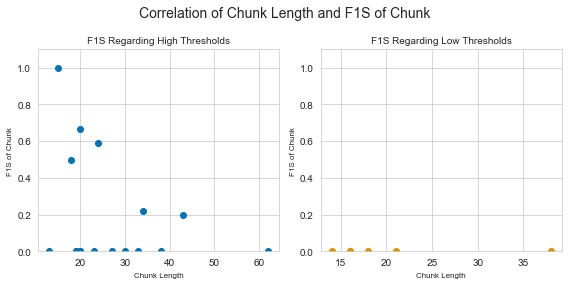

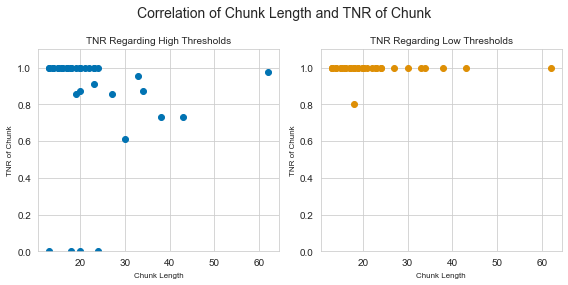

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define input length to adjust
input_length = 12

# Add column for chunk length to all chunks of matrix
chunks_matrix['LENGTH'] = chunks_matrix['N_ITERATIONS'] + input_length

for metric in ['F1S', 'TNR']:

    # Define background color, subplots and suptitle
    sns.set_style('whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(f'Correlation of Chunk Length and {metric} of Chunk', fontsize=14)

    if endogenous_input == 'MIN':
        ax1.set_visible(False)
        ax2.set_position([1, 0.2, 0.05, 0.2])
    else:
        # Extract chunks for high and low analysis plot
        high_chunks = chunks_matrix[chunks_matrix['ALARM_TYPE'] == 'High'][[metric, 'LENGTH']]

        # Introduce mean value for each length
        # Note: If mean value of metric is used, lines can be drawn again (with default of linestyle parameter)
        #high_chunks = high_chunks.astype(float)
        #high_chunks = high_chunks.groupby('LENGTH').mean()

        # Reset indices to make access via column names possible again
        high_chunks.reset_index(level=0, inplace=True)

        # Add left plot (high threshold analysis)
        ax1.plot('LENGTH', metric, data=high_chunks, marker='o', color=sns.color_palette('colorblind')[0], linestyle='None')
        ax1.set_title(f'{metric} Regarding High Thresholds', fontsize=10)
        ax1.set_xlabel('Chunk Length', fontsize=8)
        ax1.set_ylabel(f'{metric} of Chunk', fontsize=8)
        ax1.set_ylim(bottom=0, top=1.1)

    if endogenous_input == 'MAX':
        ax2.set_visible(False)
        ax1.set_position([0, 0.2, 0.05, 0.2])
    else:
        # Extract chunks for high and low analysis plot
        low_chunks = chunks_matrix[chunks_matrix['ALARM_TYPE'] == 'Low'][[metric, 'LENGTH']]

        # Introduce mean value for each length
        # Note: If mean value of metric is used, lines can be drawn again (with default of linestyle parameter)
        #low_chunks = vlow_chunks.astype(float)
        #low_chunks = low_chunks.groupby('LENGTH').mean()

        # Reset indices to make access via column names possible again
        low_chunks.reset_index(level=0, inplace=True)

        # Add right plot (low threshold analysis)
        ax2.plot('LENGTH', metric, data=low_chunks, marker='o', color=sns.color_palette('colorblind')[1], linestyle='None')
        ax2.set_title(f'{metric} Regarding Low Thresholds', fontsize=10)
        ax2.set_xlabel('Chunk Length', fontsize=8)
        ax2.set_ylabel(f'{metric} of Chunk', fontsize=8)
        ax2.set_ylim(bottom=0, top=1.1)

    # Improve layout and save figure
    fig.tight_layout()
    fig.show()
    #fig.savefig(f'../../plots/darts/{n_chunks}_chunks/correlation_chunk_length_and_{metric}_{model_type}_{parameter}_{endogenous_input}.png', dpi=1200)

### Time-Series Plot of Chunk with Prediction

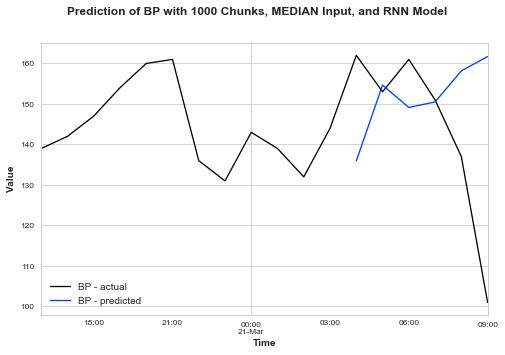

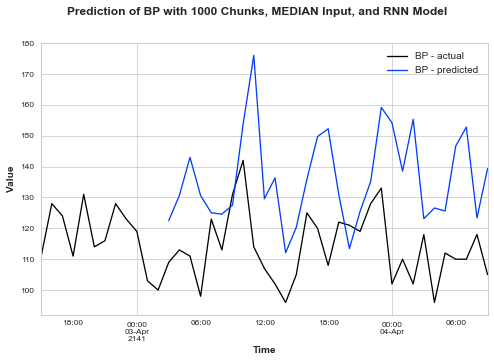

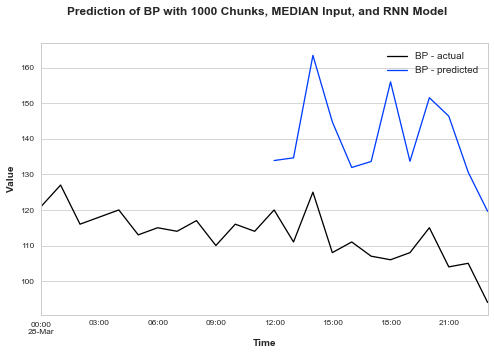

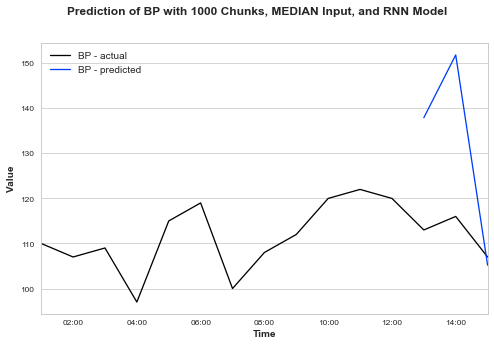

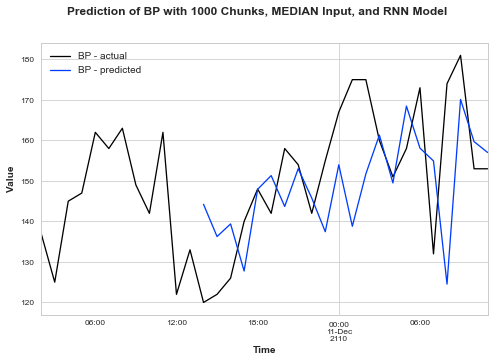

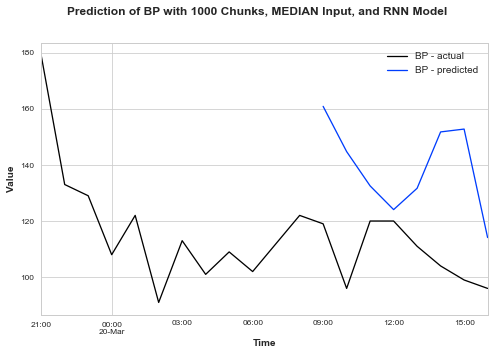

In [8]:
from darts import TimeSeries
import pandas as pd

# Define chunk IDs of current "model type-parameter-input" chunk-level matrix
chunk_ids = ['200063.0_220179.0_2141-03-20 16:00:00', '200063.0_220179.0_2141-04-02 15:24:00',
             '200098.0_220179.0_2136-03-28 00:15:00', '200098.0_220179.0_2136-03-31 01:00:00',
             '200108.0_220179.0_2110-12-10 02:00:00', '200116.0_220179.0_2198-03-19 21:43:00']

for chunk_id in chunk_ids:

    # Format chunk IDs into Windows format that have to be used when loading from or saving to Windows machine
    chunk_id_windows = chunk_id.replace(':', '%3A')

    # Extract predicted series of chunk
    prediction_chunk_f = open(f'../../data/darts/{n_chunks}_chunks/{model_type}/{parameter}/{endogenous_input}/'
                              f'05_prediction_{chunk_id_windows}.pickle', 'rb')
    prediction_chunk = pickle.load(prediction_chunk_f)
    prediction_chunk_f.close()

    # Convert predicted series of chunk to TimeSeries object
    prediction_chunk = TimeSeries.from_dataframe(
        df=prediction_chunk,
        time_col='Time',
        value_cols=['Value'],
        freq='H')

    # Extract original series of chunk
    resampled_chunks = pd.read_parquet(f'../../data/resampling/resample_output_{parameter}_first{n_chunks}.parquet', engine='pyarrow')
    original_chunk = resampled_chunks[resampled_chunks['CHUNK_ID_FILLED_TH'] == chunk_id]

    # Convert original series of chunk to TimeSeries object
    original_chunk = TimeSeries.from_dataframe(
        df=original_chunk,
        time_col='CHARTTIME',
        value_cols=[f'VITAL_PARAMTER_VALUE_{endogenous_input}_RESAMPLING'],
        freq='H')

    # Actual plot
    sns.set_style('whitegrid')
    plt.figure(figsize=(8, 5))
    original_chunk.plot(label=f'{parameter.upper()} - actual')
    prediction_chunk.plot(label=f'{parameter.upper()} - predicted')

    # Adjust texts of plot
    plt.legend()
    plt.suptitle(f'Prediction of {parameter.upper()} with {n_chunks} Chunks, {endogenous_input} Input, and {model_type} Model', fontweight='bold')
    plt.xlabel('Time')
    plt.ylabel('Value')

    plt.show()
    #plt.savefig(f'../../plots/darts/{n_chunks}_chunks/prediction_{model_type}_{parameter}_{endogenous_input}_{chunk_id_windows}.png', dpi=1200)